<a href="https://colab.research.google.com/github/RahulVerma2444/LangGraph-Stock-Referencer/blob/main/ToolCall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.2/153.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 13.6 MB/s eta 0:00:00


In [ ]:
%pip install --upgrade --quiet  langchain-community langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 786.8/786.8 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.2 MB/s eta 0:00:00


In [ ]:
from langchain.chat_models import init_chat_model
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [ ]:
class State(TypedDict):
  messages: Annotated[list, add_messages]

In [ ]:
#from secret_key import openapi_key
import os
os.environ['OPENAI_API_KEY'] = ""

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

In [ ]:
@tool
def get_stock_price(symbol: str) -> float:
  '''Return the current price of a stock given the stock symbol
  :param symbol: stock symbol
  :return: current price of the stock
  '''
  return {
      "MSFT": 200.3,
      "AAPL": 100.4,
      "AMZN": 150.0,
      "RIL": 87.6
  }.get(symbol, 0.0)

tools = [get_stock_price]

In [ ]:
llm_with_tools = llm.bind_tools(tools)

In [ ]:
def chatbot(state: State) -> State:
  return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)

builder.add_node(chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)
builder.add_edge("tools", "chatbot")


graph = builder.compile(checkpointer=memory)


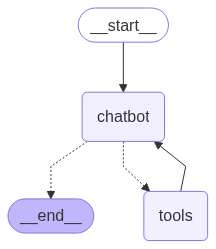

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config1 = { 'configurable': { 'thread_id': '1'}}

state = graph.invoke({"messages": [{"role": "user", "content": "I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?"}]}, config=config1)
print(state["messages"][-1].content)
print(state)

The current price of AMZN stock is $150.00, and MSFT stock is $200.30. 

To calculate the total cost:
- 20 AMZN stocks: \(20 \times 150.00 = 3,000\)
- 15 MSFT stocks: \(15 \times 200.30 = 3,004.50\)

So, the total cost will be $3,000 + $3,004.50 = $6,004.50.
{'messages': [HumanMessage(content='I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?', additional_kwargs={}, response_metadata={}, id='adf0bbf0-61ad-4602-94d0-1cb3c207a1c1'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_v4VFUsX9NhHDsRSOpDYLwZSa', 'function': {'arguments': '{"symbol": "AMZN"}', 'name': 'get_stock_price'}, 'type': 'function'}, {'id': 'call_5JFrxo0DtCy3EtfI5551XLO2', 'function': {'arguments': '{"symbol": "MSFT"}', 'name': 'get_stock_price'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 94, 'total_tokens': 142, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_t

In [ ]:
config2 = { 'configurable': { 'thread_id': '2'}}

state = graph.invoke({"messages": [{"role": "user", "content": "Tell me the current price of 5 APPL stocks."}]}, config=config2)
print(state["messages"][-1].content)
print(state)

The current price of one AAPL (Apple Inc.) stock is $100.4. Therefore, the price for 5 AAPL stocks would be \(5 \times 100.4 = 502\) dollars.
{'messages': [HumanMessage(content='Tell me the current price of 5 APPL stocks.', additional_kwargs={}, response_metadata={}, id='8f56dfc8-51dc-448b-8df5-63a76dea99bc'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_NatIHknnjgwdxQfodxoIdUgX', 'function': {'arguments': '{"symbol":"AAPL"}', 'name': 'get_stock_price'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 80, 'total_tokens': 96, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-C4AxzbvzqLaAh7k70jBOl9zuU7ydu', 'service_tier': 'default', 'finish_reason': 'too

In [ ]:
state = graph.invoke({"messages": [{"role": "user", "content": "Using the current price tell me the total price of 10 RIL stocks and add it to previous total"}]}, config=config1)
print(state["messages"][-1].content)
print(state)

The current price of RIL stock is $87.60.

To calculate the cost for 10 RIL stocks:
- 10 RIL stocks: \(10 \times 87.60 = 876.00\)

Adding this to the previous total of $6,004.50 gives us:
\[6,004.50 + 876.00 = 6,880.50\]

The new total is $6,880.50.
{'messages': [HumanMessage(content='I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?', additional_kwargs={}, response_metadata={}, id='adf0bbf0-61ad-4602-94d0-1cb3c207a1c1'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_v4VFUsX9NhHDsRSOpDYLwZSa', 'function': {'arguments': '{"symbol": "AMZN"}', 'name': 'get_stock_price'}, 'type': 'function'}, {'id': 'call_5JFrxo0DtCy3EtfI5551XLO2', 'function': {'arguments': '{"symbol": "MSFT"}', 'name': 'get_stock_price'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 94, 'total_tokens': 142, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0

In [ ]:
state = graph.invoke({"messages": [{"role": "user", "content": "Using the current price tell me the total price of 10 RIL stocks and add it to previous total"}]}, config=config2)
print(state["messages"][-1].content)
print(state)

The current price of one RIL (Reliance Industries Limited) stock is $87.6. Therefore, the price for 10 RIL stocks would be \(10 \times 87.6 = 876\) dollars.

Adding this to the previous total of $502 for 5 AAPL stocks, the combined total is \(502 + 876 = 1378\) dollars.
{'messages': [HumanMessage(content='Tell me the current price of 5 APPL stocks.', additional_kwargs={}, response_metadata={}, id='8f56dfc8-51dc-448b-8df5-63a76dea99bc'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_NatIHknnjgwdxQfodxoIdUgX', 'function': {'arguments': '{"symbol":"AAPL"}', 'name': 'get_stock_price'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 80, 'total_tokens': 96, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'syste